# 考察

最下部で複数画像を追加で、正解不正解の確認を行った。
そこで、微調整（Fine tuning）では1つ誤判定の画像(微調整 追加1 画像)があった。
一方、転移学習では同様の画像(転移学習 追加1 画像)も正常に判別できている。
おそらく、再学習用データが少なかったため、転移学習のほうが優位だったと考えられる。

In [1]:
# For tips on running notebooks in Google Colab, see
# https://pytorch.org/tutorials/beginner/colab
%matplotlib inline

Transfer Learning for Computer Vision Tutorial
==============================================

**Author**: [Sasank Chilamkurthy](https://chsasank.github.io)

In this tutorial, you will learn how to train a convolutional neural
network for image classification using transfer learning. You can read
more about the transfer learning at [cs231n
notes](https://cs231n.github.io/transfer-learning/)

Quoting these notes,

> In practice, very few people train an entire Convolutional Network
> from scratch (with random initialization), because it is relatively
> rare to have a dataset of sufficient size. Instead, it is common to
> pretrain a ConvNet on a very large dataset (e.g. ImageNet, which
> contains 1.2 million images with 1000 categories), and then use the
> ConvNet either as an initialization or a fixed feature extractor for
> the task of interest.

These two major transfer learning scenarios look as follows:

-   **Finetuning the ConvNet**: Instead of random initialization, we
    initialize the network with a pretrained network, like the one that
    is trained on imagenet 1000 dataset. Rest of the training looks as
    usual.
-   **ConvNet as fixed feature extractor**: Here, we will freeze the
    weights for all of the network except that of the final fully
    connected layer. This last fully connected layer is replaced with a
    new one with random weights and only this layer is trained.


In [2]:
# License: BSD
# Author: Sasank Chilamkurthy

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
from PIL import Image
from tempfile import TemporaryDirectory

cudnn.benchmark = True
plt.ion()   # interactive mode

Load Data
=========

We will use torchvision and torch.utils.data packages for loading the
data.

The problem we\'re going to solve today is to train a model to classify
**ants** and **bees**. We have about 120 training images each for ants
and bees. There are 75 validation images for each class. Usually, this
is a very small dataset to generalize upon, if trained from scratch.
Since we are using transfer learning, we should be able to generalize
reasonably well.

This dataset is a very small subset of imagenet.


In [3]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = '/app/data/hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Visualize a few images
======================

Let\'s visualize a few training images so as to understand the data
augmentations.


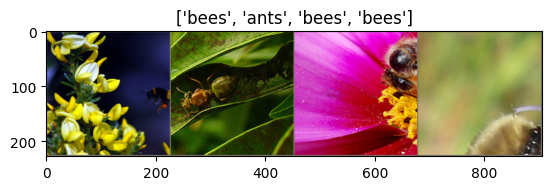

In [14]:
def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

Training the model
==================

Now, let\'s write a general function to train a model. Here, we will
illustrate:

-   Scheduling the learning rate
-   Saving the best model

In the following, parameter `scheduler` is an LR scheduler object from
`torch.optim.lr_scheduler`.


In [6]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')
    
        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0

        for epoch in range(num_epochs):
            print(f'Epoch {epoch}/{num_epochs - 1}')
            print('-' * 10)

            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode

                running_loss = 0.0
                running_corrects = 0

                # Iterate over data.
                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                if phase == 'train':
                    scheduler.step()

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]

                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

                # deep copy the model
                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)

            print()

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:4f}')

        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path, weights_only=True))
    return model

Visualizing the model predictions
=================================

Generic function to display predictions for a few images


In [21]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

Finetuning the ConvNet
======================

Load a pretrained model and reset final fully connected layer.


In [19]:
model_ft = models.resnet18(weights='IMAGENET1K_V1')
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to ``nn.Linear(num_ftrs, len(class_names))``.
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Train and evaluate
==================

It should take around 15-25 min on CPU. On GPU though, it takes less
than a minute.


In [20]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 0.5239 Acc: 0.7254
val Loss: 0.2443 Acc: 0.8954

Epoch 1/24
----------
train Loss: 0.6904 Acc: 0.7254
val Loss: 0.3890 Acc: 0.8562

Epoch 2/24
----------
train Loss: 0.5711 Acc: 0.7910
val Loss: 0.2190 Acc: 0.9412

Epoch 3/24
----------
train Loss: 0.6440 Acc: 0.7746
val Loss: 0.5654 Acc: 0.8039

Epoch 4/24
----------
train Loss: 0.5206 Acc: 0.8197
val Loss: 0.4665 Acc: 0.8431

Epoch 5/24
----------
train Loss: 0.3887 Acc: 0.8566
val Loss: 0.2420 Acc: 0.9150

Epoch 6/24
----------
train Loss: 0.3464 Acc: 0.8484
val Loss: 0.2711 Acc: 0.8758

Epoch 7/24
----------
train Loss: 0.3445 Acc: 0.8648
val Loss: 0.2344 Acc: 0.9020

Epoch 8/24
----------
train Loss: 0.3296 Acc: 0.8648
val Loss: 0.1914 Acc: 0.9346

Epoch 9/24
----------
train Loss: 0.4326 Acc: 0.8197
val Loss: 0.1767 Acc: 0.9346

Epoch 10/24
----------
train Loss: 0.2742 Acc: 0.8852
val Loss: 0.1886 Acc: 0.9346

Epoch 11/24
----------
train Loss: 0.3162 Acc: 0.8443
val Loss: 0.1803 Acc: 0.9346

Ep

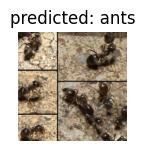

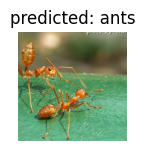

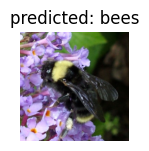

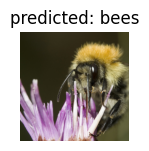

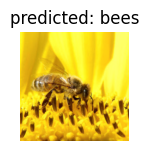

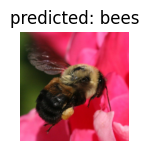

In [25]:
visualize_model(model_ft)

ConvNet as fixed feature extractor
==================================

Here, we need to freeze all the network except the final layer. We need
to set `requires_grad = False` to freeze the parameters so that the
gradients are not computed in `backward()`.

You can read more about this in the documentation
[here](https://pytorch.org/docs/notes/autograd.html#excluding-subgraphs-from-backward).


In [4]:
model_conv = torchvision.models.resnet18(weights='IMAGENET1K_V1')
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

Train and evaluate
==================

On CPU this will take about half the time compared to previous scenario.
This is expected as gradients don\'t need to be computed for most of the
network. However, forward does need to be computed.


In [31]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.4066 Acc: 0.8279
val Loss: 0.1634 Acc: 0.9477

Epoch 1/24
----------
train Loss: 0.3304 Acc: 0.8770
val Loss: 0.1769 Acc: 0.9542

Epoch 2/24
----------
train Loss: 0.3535 Acc: 0.8525
val Loss: 0.1668 Acc: 0.9542

Epoch 3/24
----------
train Loss: 0.3960 Acc: 0.8238
val Loss: 0.1678 Acc: 0.9542

Epoch 4/24
----------
train Loss: 0.3750 Acc: 0.8320
val Loss: 0.1767 Acc: 0.9412

Epoch 5/24
----------
train Loss: 0.3799 Acc: 0.8443
val Loss: 0.1625 Acc: 0.9542

Epoch 6/24
----------
train Loss: 0.2554 Acc: 0.8770
val Loss: 0.1759 Acc: 0.9412

Epoch 7/24
----------
train Loss: 0.3058 Acc: 0.8648


11763.98s - thread._ident is None in _get_related_thread!


val Loss: 0.1623 Acc: 0.9412

Epoch 8/24
----------
train Loss: 0.3655 Acc: 0.8402
val Loss: 0.1685 Acc: 0.9542

Epoch 9/24
----------
train Loss: 0.3882 Acc: 0.8238
val Loss: 0.1664 Acc: 0.9477

Epoch 10/24
----------
train Loss: 0.3489 Acc: 0.8484
val Loss: 0.1610 Acc: 0.9477

Epoch 11/24
----------
train Loss: 0.3198 Acc: 0.8607
val Loss: 0.1624 Acc: 0.9412

Epoch 12/24
----------
train Loss: 0.3641 Acc: 0.8320
val Loss: 0.1784 Acc: 0.9346

Epoch 13/24
----------
train Loss: 0.3825 Acc: 0.8525
val Loss: 0.1618 Acc: 0.9477

Epoch 14/24
----------
train Loss: 0.3496 Acc: 0.8484
val Loss: 0.1812 Acc: 0.9346

Epoch 15/24
----------
train Loss: 0.3078 Acc: 0.8770
val Loss: 0.1689 Acc: 0.9412

Epoch 16/24
----------
train Loss: 0.4318 Acc: 0.8484
val Loss: 0.1670 Acc: 0.9477

Epoch 17/24
----------
train Loss: 0.3751 Acc: 0.8238
val Loss: 0.2022 Acc: 0.9346

Epoch 18/24
----------
train Loss: 0.3669 Acc: 0.8402
val Loss: 0.1552 Acc: 0.9542

Epoch 19/24
----------
train Loss: 0.3861 Acc: 0

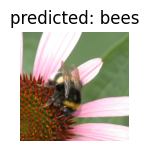

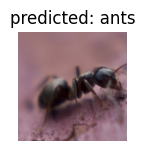

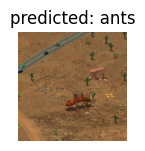

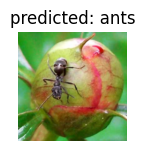

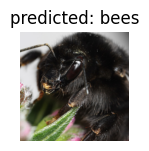

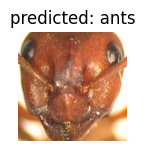

In [33]:
visualize_model(model_conv)

plt.ioff()
plt.show()

Inference on custom images
==========================

Use the trained model to make predictions on custom images and visualize
the predicted class labels along with the images.


In [23]:
def visualize_model_predictions(model,img_path):
    was_training = model.training
    model.eval()

    img = Image.open(img_path)
    img = data_transforms['val'](img)
    img = img.unsqueeze(0)
    img = img.to(device)

    with torch.no_grad():
        outputs = model(img)
        _, preds = torch.max(outputs, 1)

        ax = plt.subplot(2,2,1)
        ax.axis('off')
        ax.set_title(f'Predicted: {class_names[preds[0]]}')
        imshow(img.cpu().data[0])
        
        model.train(mode=was_training)

# 転移学習 追加1

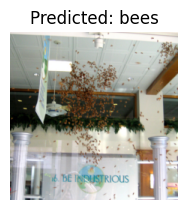

In [34]:
visualize_model_predictions(
    model_conv,
    img_path='/app/data/hymenoptera_data/val/bees/2509402554_31821cb0b6.jpg'
)

plt.ioff()
plt.show()

# 転移学習 追加2

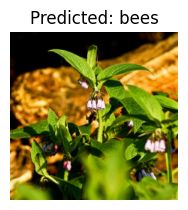

In [36]:
visualize_model_predictions(
    model_conv,
    img_path='/app/data/hymenoptera_data/val/bees/2501530886_e20952b97d.jpg'
)

plt.ioff()
plt.show()

# 微調整 追加1

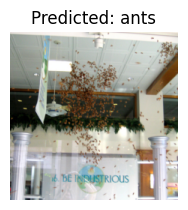

In [35]:
visualize_model_predictions(
    model_ft,
    img_path='/app/data/hymenoptera_data/val/bees/2509402554_31821cb0b6.jpg'
)

plt.ioff()
plt.show()

# 微調整 追加2

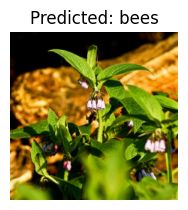

In [37]:
visualize_model_predictions(
    model_ft,
    img_path='/app/data/hymenoptera_data/val/bees/2501530886_e20952b97d.jpg'
)

plt.ioff()
plt.show()

Further Learning
================

If you would like to learn more about the applications of transfer
learning, checkout our [Quantized Transfer Learning for Computer Vision
Tutorial](https://pytorch.org/tutorials/intermediate/quantized_transfer_learning_tutorial.html).
